In [1]:
from qiskit import ClassicalRegister, QuantumCircuit, QuantumRegister
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt
import bitstring
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector

from qiskit_aer.noise import (NoiseModel, QuantumError, ReadoutError,
    pauli_error, depolarizing_error, thermal_relaxation_error)

from qiskit.circuit.library import UnitaryGate

In [2]:
matrix_h = ([[2**(-0.5),2**(-0.5)],[2**(-0.5),-2**(-0.5)]])
h_ideal = UnitaryGate(matrix_h)

matrix_cx = ([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
cx_ideal = UnitaryGate(matrix_cx)       #Erst Target, dann Control Qubit!!

matrix_x = ([[0,1],[1,0]])
x_ideal = UnitaryGate(matrix_x)

matrix_z = ([[1,0],[0,-1]])
z_ideal = UnitaryGate(matrix_z)

In [3]:
def rot_surf_code(n: int) -> QuantumCircuit:              #1st anc = third last qubit = syndrome/parity measurement qubit, 2nd anc = sec last qubit = magic state for S Gate, 3rd anc = last qubit = magic state for T-Gate
    qr = QuantumRegister(9*n+1, "q")
    cbit = ClassicalRegister(9,"c")
    qc = QuantumCircuit(qr,cbit)
    for i in range(n):
        qc.h(9*i+1)
        qc.h(9*i+3)
        qc.h(9*i+5)
        qc.h(9*i+7)

        qc.cx(9*i+1,9*i)
        qc.cx(9*i+5,9*i+4)
        qc.cx(9*i+7,9*i+8)

        qc.cx(9*i+5,9*i+2)

        qc.cx(9*i+3,9*i+4)
        qc.cx(9*i+2,9*i+1)

        qc.cx(9*i+3,9*i+6)

        qc.cx(9*i+6,9*i+7)
    return qc

def X_L(qc: QuantumCircuit, had = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will X_L auf den ersten anwenden ---> n = 0 !!!
    if had:
        qc.x(9*n+3)
        qc.x(9*n+4)
        qc.x(9*n+5)
    else:
        qc.x(9*n+1)
        qc.x(9*n+4)
        qc.x(9*n+7)

def Z_L(qc: QuantumCircuit, had = False, n=0):            #n muss bei 0 anfangen, also z.B. man hat 3 Circuits und will Z_L auf den ersten anwenden ---> n = 0 !!!
    if had:
        qc.z(9*n+1)
        qc.z(9*n+4)
        qc.z(9*n+7)
    else:
        qc.z(9*n+3)
        qc.z(9*n+4)
        qc.z(9*n+5)

def H_L(qc: QuantumCircuit, pos=0):              #H-Gates auf EINEN Circuit, wieder erster Circuit --> n = 0, zweiter Circuit --> n = 1 , usw.
    for i in range(9):
        qc.h(9*pos+i)

def S_L(qc: QuantumCircuit, had = False, pos=0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.s(anc)

    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)

def adj_S_L(qc: QuantumCircuit, had = False, pos=0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.sdg(anc)

    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.z(3+9*pos)
            qc.z(4+9*pos)
            qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.z(1+9*pos)
            qc.z(4+9*pos)
            qc.z(7+9*pos)
    
def T_L(qc: QuantumCircuit, had = False, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.t(anc)

    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(3+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(5+9*pos, anc) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.s(anc)
            qc.cx(1+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(7+9*pos, anc) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

def adj_T_L(qc: QuantumCircuit, had = False, pos = 0):
    anc = qc.num_qubits - 1
    qc.reset(anc)

    #qc.h(magic_S)
    qc.append(h_ideal,[anc])
    qc.tdg(anc)

    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)        
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)  

    qc.measure(anc, 0)

    if had == False:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.cx(3+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(5+9*pos, anc) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(3+9*pos)
                qc.z(4+9*pos)
                qc.z(5+9*pos)
    else:
        with qc.if_test((0,1)):
            qc.reset(anc)
            qc.append(h_ideal,[anc])
            qc.sdg(anc)
            qc.cx(1+9*pos, anc)
            qc.cx(4+9*pos, anc)
            qc.cx(7+9*pos, anc) 
            qc.measure(anc, 0)
            with qc.if_test((0,1)):
                qc.z(1+9*pos)
                qc.z(4+9*pos)
                qc.z(7+9*pos)

def CNOT(qc:QuantumCircuit, had = "00", control = 0):               #CNOT mit berücksichtigung der Rotation durch H-Gate
    if control == 0:
        if had == "10":
            qc.cx(0,9+6)
            qc.cx(1,9+3)
            qc.cx(2,9+0)
            qc.cx(3,9+7)
            qc.cx(4,9+4)
            qc.cx(5,9+1)
            qc.cx(6,9+8)
            qc.cx(7,9+5)
            qc.cx(8,9+2)
        elif had == "01":
            qc.cx(0,9+2)
            qc.cx(1,9+5)
            qc.cx(2,9+8)
            qc.cx(3,9+1)
            qc.cx(4,9+4)
            qc.cx(5,9+7)
            qc.cx(6,9+0)
            qc.cx(7,9+3)
            qc.cx(8,9+6)
        else:
            for i in range(9):
                qc.cx(i,9+i)
    elif control == 1:
        if had == "01":
            qc.cx(9+0,6)
            qc.cx(9+1,3)
            qc.cx(9+2,0)
            qc.cx(9+3,7)
            qc.cx(9+4,4)
            qc.cx(9+5,1)
            qc.cx(9+6,8)
            qc.cx(9+7,5)
            qc.cx(9+8,2)
        elif had == "10":
            qc.cx(9+0,2)
            qc.cx(9+1,5)
            qc.cx(9+2,8)
            qc.cx(9+3,1)
            qc.cx(9+4,4)
            qc.cx(9+5,7)
            qc.cx(9+6,0)
            qc.cx(9+7,3)
            qc.cx(9+8,6)
        else: 
            for i in range(9):
                qc.cx(9+i,i)

def control_S_L(qc: QuantumCircuit, had = "00"):
    if had == "01":
        T_L(qc, had=False, pos=0)
        T_L(qc, had=True, pos=1)
        CNOT(qc, had=had, control=0)
        adj_T_L(qc, had=True, pos=1)
        CNOT(qc, had=had, control=0)
    elif had == "10":
        T_L(qc, had=True, pos=0)
        T_L(qc, had=False, pos=1)
        CNOT(qc, had=had, control=0)
        adj_T_L(qc, had=False, pos=1)
        CNOT(qc, had=had, control=0)
    else:   #had = "00" = "11"
        T_L(qc, had=False, pos=0)
        T_L(qc, had=False, pos=1)
        CNOT(qc, had=had, control=0)
        adj_T_L(qc, had=False, pos=1)
        CNOT(qc, had=had, control=0)

def control_Z_L(qc: QuantumCircuit):
    H_L(qc, pos = 1)
    CNOT(qc, control = 0)            #aufgrund des H eine Zeile drüber, geht das normale CNOT
    H_L(qc, pos = 1)

def readout(qc: QuantumCircuit, had: False, pos: int, shots: int, noise = 0):
    anc = qc.num_qubits - 1

    qc.reset(anc)
    
    if had == False:
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)
    else:
        qc.cx(1+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(7+9*pos, anc)
    
    qc.measure(anc, 3)

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    x_old = list(counts.keys())
    x_old = [j[0] for j in x_old]
    y_old = list(counts.values())

    ones  =  0
    for j in range(len(x_old)):
        if x_old[j] == "1":
            ones += y_old[j]
    ones = ones/shots

    zeros = 1 - ones

    return zeros, ones

def readout_new(qc: QuantumCircuit, had: int, pos: int, shots: int, noise = 0):
    code0 = ['000110101', '110110110', '110110101', '110000000', '000110110', '101101101', '011101101', '011011000', '011011011', '110000011', '000000000', '011101110', '101011011', '101101110', '000000011', '101011000']
    code1 = ['010100111', '010010001', '111111111', '001001010', '111001010', '001111111', '100010010', '111111100', '100100100', '100010001', '001001001', '010010010', '100100111', '111001001', '001111100', '010100100']#

    if had%4 == 0:
        for i in range(9):
            qc.measure(i+9*pos, 8-i)
    elif had%4 == 1:
        qc.measure(0+9*pos, 8-6)
        qc.measure(1+9*pos, 8-3)
        qc.measure(2+9*pos, 8-0)
        qc.measure(3+9*pos, 8-7)
        qc.measure(4+9*pos, 8-4)
        qc.measure(5+9*pos, 8-1)
        qc.measure(6+9*pos, 8-8)
        qc.measure(7+9*pos, 8-5)
        qc.measure(8+9*pos, 8-2)
    elif had%4 == 2:
        for i in range(9):
            qc.measure(i+9*pos, i)
    elif had%4 == 3:
        qc.measure(0+9*pos, 8-2)
        qc.measure(1+9*pos, 8-5)
        qc.measure(2+9*pos, 8-8)
        qc.measure(3+9*pos, 8-1)
        qc.measure(4+9*pos, 8-4)
        qc.measure(5+9*pos, 8-7)
        qc.measure(6+9*pos, 8-0)
        qc.measure(7+9*pos, 8-3)

    p = noise
    p_error = pauli_error([["X",p/2],["I",1-p],["Z",p/2]])
    p_error_2 = pauli_error([["XX",p/6],["XI",p/6],["IX",p/6],["II",1-p],["ZZ",p/6],["ZI",p/6],["IZ",p/6]])

    noise_model = NoiseModel()
    noise_model.add_all_qubit_quantum_error(p_error, ['x', "z", 'h'])  # Apply to single-qubit gates
    noise_model.add_all_qubit_quantum_error(p_error_2, ['cx'])  # Apply to 2-qubit gates

    sim = AerSimulator()
    job = sim.run(qc, noise_model = noise_model, shots=shots)
    result = job.result()
    counts = result.get_counts()

    bits = list(counts.keys())
    hmm = list(counts.values())

    for i in range(len(bits)):
        for j in code0:
            if j == bits[i]:
                bits[i] = 0
                break
        if bits[i] != 0:
            for j in code1:
                if j == bits[i]:
                    bits[i] = 1
                    break
        if bits[i] != 1 and bits[i] != 0:
            bits[i] = 2

    ones = 0
    zeros = 0
    err = 0

    for i in range(len(bits)):
        if bits[i] == 0:
            zeros += hmm[i]
        if bits[i] == 1:
            ones += hmm[i]
        if bits[i] == 2:
            err += hmm[i]
    
    ones = (ones/shots)
    zeros = (zeros/shots)
    err = (err/shots)

    return zeros, ones, err

def stabilize(qc: QuantumCircuit, had = False, pos = 0):
    anc = qc.num_qubits - 1
    if had:
        #X3 X6 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, 6+9*pos)
        qc.h(anc)
        qc.measure(anc,0)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 0+9*pos)
        qc.cx(anc, 1+9*pos)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, 4+9*pos)
        qc.h(anc)
        qc.measure(anc,1)

        #X4 X5 X7 X8 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, 5+9*pos)
        qc.cx(anc, 7+9*pos)
        qc.cx(anc, 8+9*pos)
        qc.h(anc)
        qc.measure(anc,2)

        #X2 X5 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 2+9*pos)
        qc.cx(anc, 5+9*pos)
        qc.h(anc)
        qc.measure(anc,3)

        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.z(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.z(3+9*pos)

        with qc.if_test((3,1)):             #2
            with qc.if_test((2,0)):
                qc.z(2+9*pos)
        
        with qc.if_test((3,1)):             #5
            with qc.if_test((2,1)):
                qc.z(5+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.z(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(7+9*pos)

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(anc)
        qc.cx(0+9*pos, anc)
        qc.cx(1+9*pos, anc)
        qc.measure(anc,0)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(anc)
        qc.cx(1+9*pos, anc)
        qc.cx(2+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)
        qc.measure(anc,1)
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(anc)
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.cx(6+9*pos, anc)
        qc.cx(7+9*pos, anc)
        qc.measure(anc,2)

        #Z7 Z8 Stabilizer:
        qc.reset(anc)
        qc.cx(7+9*pos, anc)
        qc.cx(8+9*pos, anc)
        qc.measure(anc,3)
        
        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):
                qc.x(0+9*pos)

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.x(1+9*pos)
        
        with qc.if_test((3,1)):             #8
            with qc.if_test((2,0)):
                qc.x(8+9*pos)
        
        with qc.if_test((3,1)):             #7
            with qc.if_test((2,1)):
                qc.x(7+9*pos)
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(2+9*pos)
        
        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(3+9*pos)

    else:
        #X0 X1 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 0+9*pos)
        qc.cx(anc, 1+9*pos)
        qc.h(anc)
        qc.measure(anc,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 1+9*pos)
        qc.cx(anc, 2+9*pos)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, 5+9*pos)
        qc.h(anc)
        qc.measure(anc,1)

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 3+9*pos)
        qc.cx(anc, 4+9*pos)
        qc.cx(anc, 6+9*pos)
        qc.cx(anc, 7+9*pos)
        qc.h(anc)
        qc.measure(anc,2)

        #X7 X8 Stabilizer:
        qc.reset(anc)
        qc.h(anc)
        qc.cx(anc, 7+9*pos)
        qc.cx(anc, 8+9*pos)
        qc.h(anc)
        qc.measure(anc,3)

        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):    
                qc.z(0+9*pos)

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.z(1+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.z(4+9*pos)

        with qc.if_test((2,1)):             #7
            with qc.if_test((3,1)):
                qc.z(7+9*pos)

        with qc.if_test((2,0)):             #8
            with qc.if_test((3,1)):
                qc.z(8+9*pos)

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):        
                with qc.if_test((2,0)):    
                    qc.z(2+9*pos)

        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.z(3+9*pos)

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(anc)
        qc.cx(3+9*pos, anc)
        qc.cx(6+9*pos, anc)
        qc.measure(anc,0)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(anc)
        qc.cx(0+9*pos, anc)
        qc.cx(1+9*pos, anc)
        qc.cx(3+9*pos, anc)
        qc.cx(4+9*pos, anc)
        qc.measure(anc,1)
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(anc)
        qc.cx(4+9*pos, anc)
        qc.cx(5+9*pos, anc)
        qc.cx(7+9*pos, anc)
        qc.cx(8+9*pos, anc)
        qc.measure(anc,2)

        #Z2 Z5 Stabilizer:
        qc.reset(anc)
        qc.cx(2+9*pos, anc)
        qc.cx(5+9*pos, anc)
        qc.measure(anc,3)
        
        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.x(6+9*pos)

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.x(3+9*pos)

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.x(4+9*pos)

        with qc.if_test((2,0)):             #2
            with qc.if_test((3,1)):
                qc.x(2+9*pos)

        with qc.if_test((2,1)):             #5
            with qc.if_test((3,1)):
                qc.x(5+9*pos)
        
        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.x(0+9*pos)
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.x(7+9*pos)

def stabilize_ideal(qc: QuantumCircuit, had = False, pos = 0):                     #misst alle stabilizer, speichert den Fehler und korrigiert dementsprechend
    ancilla = qc.num_qubits - 1
    if had:
        #X3 X6 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [6+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,0)

        #X0 X1 X3 X4 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [0+9*pos, ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,1)

        #X4 X5 X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(cx_ideal, [8+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,2)

        #X2 X5 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [2+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.append(z_ideal,[6+9*pos])

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.append(z_ideal,[3+9*pos])

        with qc.if_test((3,1)):             #2
            with qc.if_test((2,0)):
                qc.append(z_ideal,[2+9*pos])
        
        with qc.if_test((3,1)):             #5
            with qc.if_test((2,1)):
                qc.append(z_ideal,[5+9*pos])
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(z_ideal,[4+9*pos])

        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(z_ideal,[0+9*pos])
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(z_ideal,[7+9*pos])

    ###########################################################################################################

        #Z0 Z1 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 0+9*pos])
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.measure(ancilla,0)

        #Z1 Z2 Z4 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.append(cx_ideal, [ancilla, 2+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.measure(ancilla,1)
    
        #Z3 Z4 Z6 Z7 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 6+9*pos])
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.measure(ancilla,2)

        #Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.append(cx_ideal, [ancilla, 8+9*pos])
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):
                qc.append(x_ideal,[0+9*pos])

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.append(x_ideal,[1+9*pos])
        
        with qc.if_test((3,1)):             #8
            with qc.if_test((2,0)):
                qc.append(x_ideal,[8+9*pos])
        
        with qc.if_test((3,1)):             #7
            with qc.if_test((2,1)):
                qc.append(x_ideal,[7+9*pos])
        
        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(x_ideal,[4+9*pos])

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(x_ideal,[2+9*pos])
        
        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(x_ideal,[3+9*pos])

    else:
        #X0 X1 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [0+9*pos, ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,0)
        
        #X1 X2 X4 X5 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [1+9*pos, ancilla])
        qc.append(cx_ideal, [2+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [5+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,1)

        #X3 X4 X6 X7 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [3+9*pos, ancilla])
        qc.append(cx_ideal, [4+9*pos, ancilla])
        qc.append(cx_ideal, [6+9*pos, ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,2)

        #X7 X8 Stabilizer:
        qc.reset(ancilla)
        qc.append(h_ideal, [ancilla])
        qc.append(cx_ideal, [7+9*pos, ancilla])
        qc.append(cx_ideal, [8+9*pos, ancilla])
        qc.append(h_ideal, [ancilla])
        qc.measure(ancilla,3)

        with qc.if_test((0,1)):             #0
            with qc.if_test((1,0)):    
                qc.append(z_ideal,[0+9*pos])

        with qc.if_test((0,1)):             #1
            with qc.if_test((1,1)):
                qc.append(z_ideal,[1+9*pos])

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(z_ideal,[4+9*pos])

        with qc.if_test((2,1)):             #7
            with qc.if_test((3,1)):
                qc.append(z_ideal,[7+9*pos])

        with qc.if_test((2,0)):             #8
            with qc.if_test((3,1)):
                qc.append(z_ideal,[8+9*pos])

        with qc.if_test((0,0)):             #2 und 5
            with qc.if_test((1,1)):        
                with qc.if_test((2,0)):    
                    qc.append(z_ideal,[2+9*pos])

        with qc.if_test((1,0)):             #3 und 6
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(z_ideal,[3+9*pos])

    ###########################################################################################################

        #Z3 Z6 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 6+9*pos])
        qc.measure(ancilla,0)

        #Z0 Z1 Z3 Z4 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 0+9*pos])
        qc.append(cx_ideal, [ancilla, 1+9*pos])
        qc.append(cx_ideal, [ancilla, 3+9*pos])
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.measure(ancilla,1)
    
        #Z4 Z5 Z7 Z8 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 4+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.append(cx_ideal, [ancilla, 7+9*pos])
        qc.append(cx_ideal, [ancilla, 8+9*pos])
        qc.measure(ancilla,2)

        #Z2 Z5 Stabilizer:
        qc.reset(ancilla)
        qc.append(cx_ideal, [ancilla, 2+9*pos])
        qc.append(cx_ideal, [ancilla, 5+9*pos])
        qc.measure(ancilla,3)
        
        with qc.if_test((0,1)):             #6
            with qc.if_test((1,0)):
                qc.append(x_ideal,[6+9*pos])

        with qc.if_test((0,1)):             #3
            with qc.if_test((1,1)):
                qc.append(x_ideal,[3+9*pos])

        with qc.if_test((1,1)):             #4
            with qc.if_test((2,1)):
                qc.append(x_ideal,[4+9*pos])

        with qc.if_test((2,0)):             #2
            with qc.if_test((3,1)):
                qc.append(x_ideal,[2+9*pos])

        with qc.if_test((2,1)):             #5
            with qc.if_test((3,1)):
                qc.append(x_ideal,[5+9*pos])
        
        with qc.if_test((0,0)):             #0 und 1
            with qc.if_test((1,1)):
                with qc.if_test((2,0)):
                    qc.append(x_ideal,[0+9*pos])
        
        with qc.if_test((1,0)):             #7 und 8
            with qc.if_test((2,1)):
                with qc.if_test((3,0)):
                    qc.append(x_ideal,[7+9*pos])

def QEC(qc: QuantumCircuit, had = False, pos = 0, iterations = 1, noise = False):
    for i in range(iterations):
        if noise == False:
            stabilize_ideal(qc=qc, had=had, pos=pos)
        else:
            stabilize(qc=qc, had=had, pos=pos)

def gates(qc:QuantumCircuit):
    qc = qc
    hmm = dict(qc.count_ops())
    return print("Amount of gates in this circuit: ", sum(hmm.values()))

In [16]:
qr = QuantumRegister(9, "q")
cbit = ClassicalRegister(9,"c")
qc = QuantumCircuit(qr,cbit)
for i in range(1):
    qc.h(9*i+1)
    qc.h(9*i+3)
    qc.h(9*i+5)
    qc.h(9*i+7)

    qc.cx(9*i+1,9*i)
    qc.cx(9*i+5,9*i+4)
    qc.cx(9*i+7,9*i+8)

    qc.cx(9*i+5,9*i+2)

    qc.cx(9*i+3,9*i+4)
    qc.cx(9*i+2,9*i+1)

    qc.cx(9*i+3,9*i+6)

    qc.cx(9*i+6,9*i+7)

qc.x(1)
qc.x(4)
qc.x(7)

for i in range(9):
    qc.measure(i,8-i)

sim = AerSimulator()
job = sim.run(qc, shots=100000)
result = job.result()
counts = result.get_counts()

codewords = list(counts.keys())
prob = list(counts.values())

print(codewords)
print(prob)

['010100111', '010010001', '111111111', '001001010', '111001010', '001111111', '100010010', '111111100', '100100100', '100010001', '001001001', '010010010', '100100111', '111001001', '001111100', '010100100']
[6161, 6387, 6198, 6405, 6157, 6207, 6267, 6324, 6083, 6329, 6300, 6248, 6258, 6348, 6207, 6121]


In [5]:
qc = rot_surf_code(2)

X_L(qc, False, n = 1)
H_L(qc, pos=0)
control_Z_L(qc)
H_L(qc ,pos=0)

zeros, ones, err = readout_new(qc, False, 0, 1000, 0.1)

print("0: ", zeros)
print("1: ", ones)
print("Postselected: ", err)

0:  0.019
1:  0.122
Postselected:  0.859


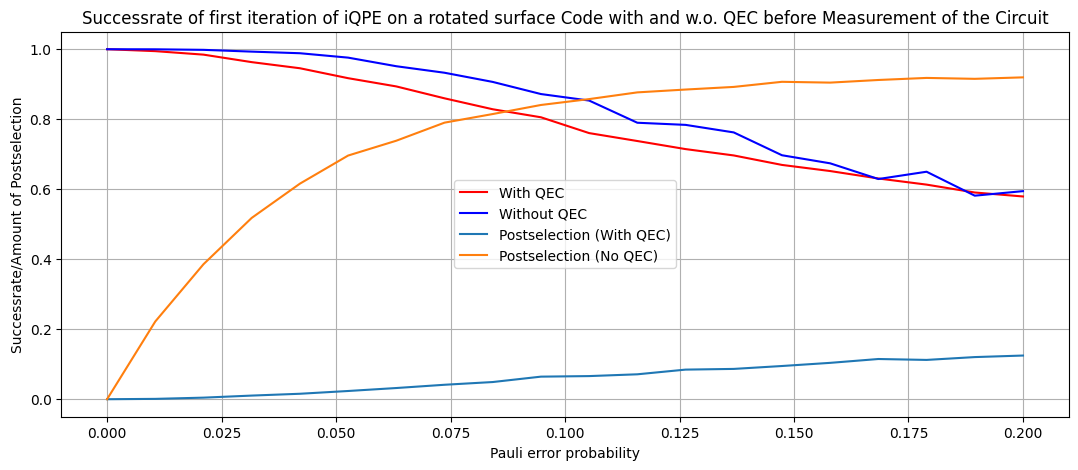

In [4]:
x = np.linspace(0,0.2,20)
y = []
y_no_QEC = []
post = []
post_no_QEC =[]
one, zero, postselec, one_QEC, zero_QEC, postselec_QEC = [],[],[],[],[],[]
shots = 10000
for i in x:
    qc = rot_surf_code(2)

    QEC(qc, pos= 0, had=False, iterations = 1, noise = False)
    QEC(qc, pos= 1, had=False, iterations = 1, noise = False)

    X_L(qc, False, n = 1)
    QEC(qc, pos= 1, had=False, iterations = 1, noise = False)
    H_L(qc, pos=0)
    QEC(qc, pos= 0, had=True, iterations = 1, noise = False)
    control_Z_L(qc)
    H_L(qc ,pos=0)

    QEC(qc, pos= 0, had=False, iterations = 1, noise = False)

    zeros, ones, err = readout_new(qc, False, 0, shots, i)

    y.append(ones/(ones+zeros))
    post.append(err)
    one_QEC.append(ones), zero_QEC.append(zeros), postselec_QEC.append(err)
    ######################################## Nochmal aber ohne QEC
    qc = rot_surf_code(2)

    X_L(qc, False, n = 1)
    H_L(qc, pos=0)
    control_Z_L(qc)
    H_L(qc ,pos=0)

    zeros, ones, err = readout_new(qc, False, 0, shots, i)

    y_no_QEC.append(ones/(ones+zeros))
    post_no_QEC.append(err)
    one.append(ones), zero.append(zeros), postselec.append(err)

data = np.array((x,zero,one,postselec,zero_QEC,one_QEC,postselec_QEC))
np.savetxt("Plots/text/RotCode_1st_Pauli_10k.txt", data, delimiter=",")

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue")
ax.plot(x,post,label="Postselection (With QEC)")
ax.plot(x,post_no_QEC,label="Postselection (No QEC)")
plt.title("Successrate of first iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate/Amount of Postselection")
plt.grid()
plt.legend()
plt.show()

In [108]:
qc = rot_surf_code(2)
X_L(qc, False, 1)
H_L(qc, 0)
control_S_L(qc, "10")
adj_S_L(qc, had=True, pos = 0)
H_L(qc, 0)

zeros, ones, err = readout_new(qc, had=2, pos=0, shots=100, noise=0.0)

print("0: ", zeros, "%")
print("1: ", ones, "%")
print("Postselected: ", err,"%")

0:  100.0 %
1:  0.0 %
Postselected:  0.0 %


Amount of gates in this circuit:  104


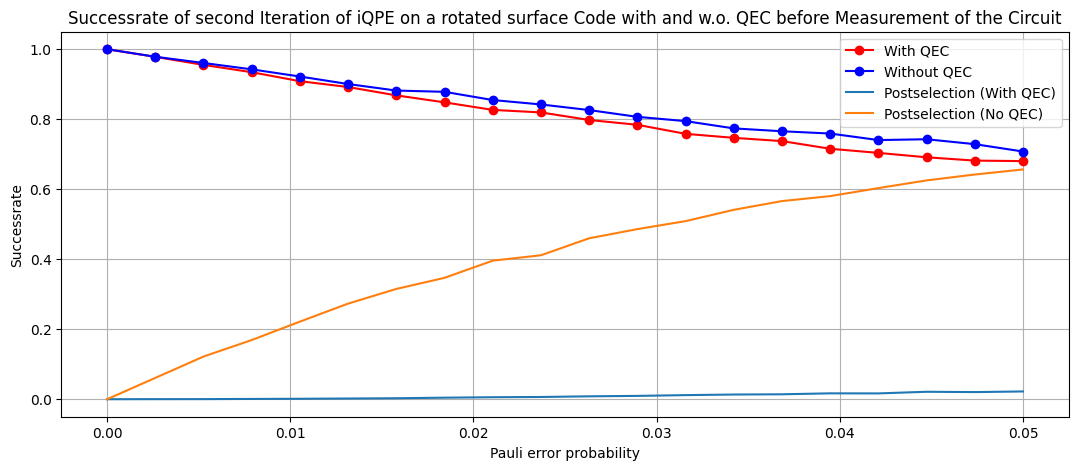

In [5]:
shots = 10000
x = np.linspace(0,0.05,20)
y = []
y_no_QEC = []
post = []
post_no_QEC = []
one, zero, postselec, one_QEC, zero_QEC, postselec_QEC = [],[],[],[],[],[]
for i in x:
    qc = rot_surf_code(2)
    X_L(qc, n = 1)
    H_L(qc, 0)

    #qc = control_S_L(qc,"10",control = 0, target = 1)

    T_L(qc, had=True, pos=0)
    T_L(qc, had=False, pos=1)

    QEC(qc, True, pos = 0, iterations=1, noise = False)
    QEC(qc, False, pos = 1, iterations=1, noise = False)

    CNOT(qc, had="10",control=0)
    adj_T_L(qc,had=False,pos=1)
    CNOT(qc, had="10",control=0)
    adj_S_L(qc, had=True, pos = 0)
    H_L(qc, 0)

    QEC(qc, False, pos = 0, iterations=1, noise = False)

    zeros, ones, err = readout_new(qc, had=2, pos=0, shots=shots, noise=i)

    y.append(zeros/(ones+zeros))
    post.append(err)
    one_QEC.append(ones), zero_QEC.append(zeros), postselec_QEC.append(err)
    ######################################## Nochmal aber ohne QEC

    qc = rot_surf_code(2)
    X_L(qc, n = 1)
    H_L(qc, 0)
    control_S_L(qc, "10")
    adj_S_L(qc, had=True, pos = 0)
    H_L(qc, 0)

    zeros, ones, err = readout_new(qc, had=2, pos=0, shots=shots, noise=i)
    y_no_QEC.append(zeros/(ones+zeros))
    post_no_QEC.append(err)
    one.append(ones), zero.append(zeros), postselec.append(err)

data = np.array((x,zero,one,postselec,zero_QEC,one_QEC,postselec_QEC))
np.savetxt("Plots/text/RotCode_2nd_Pauli_10k.txt", data, delimiter=",")
gates(qc)

fig, ax = plt.subplots(figsize=(13,5))

ax.plot(x,y,label = "With QEC", color="red", marker = "o")
ax.plot(x,y_no_QEC, label = "Without QEC", color="blue", marker = "o")
ax.plot(x,post,label="Postselection (With QEC)")
ax.plot(x,post_no_QEC,label="Postselection (No QEC)")
plt.title("Successrate of second Iteration of iQPE on a rotated surface Code with and w.o. QEC before Measurement of the Circuit")
plt.xlabel("Pauli error probability")
plt.ylabel("Successrate")
plt.grid()
plt.legend()
plt.show()